In [1]:
import tqdm, os, torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from pyDOE import lhs
import scipy.interpolate as interpolate


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
os.makedirs('figures', exist_ok=True)

In [4]:
def to_tensor(d):
    return torch.from_numpy(d).float().to(device, dtype=torch.float32)

### Define the PDE function

Wavefield is a function of time and space coordinates $u=u(t, \textit{\textbf{x}}), \textit{\textbf{x}}=(x,z) \in  \mathbb{D}^2 \in  \mathbb{R}^2$, which satifies:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial z^2}\right)
$$

### Boundary conditions 
$$u(t, \textit{\textbf{x}}=\textit{\textbf{x}}_\textit{0})=s(t)$$
$$u(t_1, \textit{\textbf{x}})=u_1$$
$$u(t_2, \textit{\textbf{x}})=u_2$$


<!-- $$u(t, \textit{\textbf{x}}\notin \mathbb{D}^2)=0$$ -->


In [5]:
# Define the PINN
class PINN(torch.nn.Module):
    def __init__(self, layers):
        super().__init__() 
        self.act = nn.Tanh()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.layers[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.layers[i].bias.data)   

    def forward(self, x, z, t):
        a = torch.concatenate((x, z, t), 1)
        for i in range(len(self.layers)-2):  
            z = self.layers[i](a)              
            a = self.act(z)    
        a = self.layers[-1](a)
        return a

In [6]:
# load the config from file
import yaml
with open('forward.yml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
end_time = config['geom']['nt']*config['geom']['dt']
vel=np.load(config['geom']['truePath']['vp'])
gridnz, gridnx=vel.shape
dh = config['geom']['h']/1000.
(nz, nx)=(gridnz*dh, gridnx*dh)
print(f"The size of the model is {nz} km x {nx} km")
print(f"The modeling time is {end_time} s")

The size of the model is 2.57 km x 2.57 km
The modeling time is 1.5 s


In [7]:
# load wavefield from disk
import glob
pmln = 50
wf_files = sorted(glob.glob("./wavefield/*.npy"))

wf = np.zeros((len(wf_files), gridnz, gridnx))
for i, wf_file in enumerate(wf_files):
    wf[i] = np.load(wf_file)[0,:,:]
print(f"The shape of the wavefield is {wf.shape}")

The shape of the wavefield is (2000, 257, 257)


In [8]:
# Downsample the data
time_samples = 10
start_time_in_sec = 0.4#s
end_time_in_sec = .8#s
samples_per_time = 2000
downsample = 4
dh = config['geom']['h']
dt = config['geom']['dt']

start_time = int(start_time_in_sec//config['geom']['dt'])
end_time = int(end_time_in_sec//config['geom']['dt'])
print(f"Start time: {start_time_in_sec} s")
print(f"End time: {end_time_in_sec} s")

Start time: 0.4 s
End time: 0.8 s


### Load the initial conditon at 0.4s and 0.5s

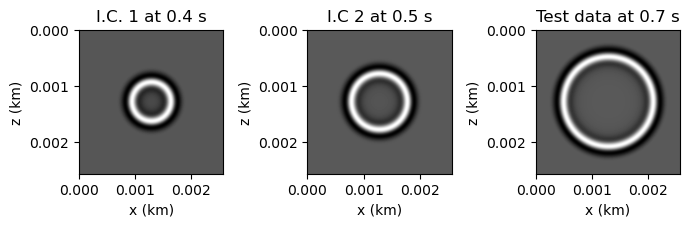

In [9]:
# initial condition 1
t1 = start_time
u0 = wf[t1]
# initial condition 2
t2 = start_time+100
u1 = wf[t2]
t3 = end_time-100
u_test = wf[t3]

fig, ax = plt.subplots(1,3, figsize=(7,3))
extent = [0, nx/1000, nz/1000, 0]
kwargs = {'extent': extent, 'cmap': 'gray', 'aspect': 'auto'}
ax[0].imshow(u0, **kwargs)
ax[1].imshow(u1, **kwargs)
ax[2].imshow(u_test, **kwargs)

ax[0].set_title(f"I.C. 1 at {t1*config['geom']['dt']} s")
ax[1].set_title(f"I.C 2 at {t2*config['geom']['dt']} s")
ax[2].set_title(f"Test data at {t3*config['geom']['dt']:.1f} s")

for ax in ax.ravel():
    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (km)')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


### Downsacle the initial conditon

In [10]:
shape_before = u0.shape
u0 = u0[::downsample, ::downsample]
u1 = u1[::downsample, ::downsample]
u_test = u_test[::downsample, ::downsample]

shape_after = u0.shape
print(f"Shape before downsampling: {shape_before}")
print(f"Shape after downsampling: {shape_after}")
# Generate grid
gridnz, gridnx = u0.shape
dh = config['geom']['h']

xx, zz = np.meshgrid(np.linspace(0,nx,gridnx),np.linspace(0,nz,gridnz))
xx0 = to_tensor(xx.reshape((-1,1)))
zz0 = to_tensor(zz.reshape((-1,1)))
#for enforcing the disp I.C 1
tt0 = 0.0*np.ones(gridnx*gridnz)
tt0 = to_tensor(tt0.reshape((-1,1)))
#for enforcing the sec I.C 2
tt1 = (t2-t1)*dt*np.ones(gridnx*gridnz)
tt1 = to_tensor(tt1.reshape((-1,1)))
# Test data
tt_test = (t3-t1)*dt*np.ones(gridnx*gridnz)
tt_test = to_tensor(tt_test.reshape((-1,1)))
print(f"The pinn will be trained at {tt1.max():.1f}s, {tt0.max():.1f}s and tested at {tt_test.max():.1f}s")

Shape before downsampling: (257, 257)
Shape after downsampling: (65, 65)
The pinn will be trained at 0.1s, 0.0s and tested at 0.3s


In [11]:
print(xx0.max(), zz0.max(), tt0.max())
print(xx0.max(), zz0.max(), tt1.max())
print(xx0.max(), zz0.max(), tt_test.max())

tensor(2.5700, device='cuda:0') tensor(2.5700, device='cuda:0') tensor(0., device='cuda:0')
tensor(2.5700, device='cuda:0') tensor(2.5700, device='cuda:0') tensor(0.1000, device='cuda:0')
tensor(2.5700, device='cuda:0') tensor(2.5700, device='cuda:0') tensor(0.3000, device='cuda:0')


In [12]:
print(u0.max(), u0.min(), u1.max(), u1.min(), u_test.max(), u_test.min())

3.244534969329834 -1.6633715629577637 2.7130141258239746 -1.4540605545043945 2.144488573074341 -1.1823393106460571


In [13]:
# After downsampling
# fig, ax = plt.subplots(1,3, figsize=(7,3))
# extent = [0, nx/1000, nz/1000, 0]
# ax[0].imshow(u0, extent=extent, cmap='gray')
# ax[1].imshow(u1, extent=extent, cmap='gray')
# ax[2].imshow(u_test, extent=extent, cmap='gray')

# ax[0].set_title(f"Initial Condition 1 at {t1*config['geom']['dt']} s")
# ax[1].set_title(f"Initial Condition 2 at {t2*config['geom']['dt']} s")
# ax[2].set_title(f"Test data at {t3*config['geom']['dt']} s")

# for ax in ax.ravel():
#     ax.set_xlabel('x (km)')
#     ax.set_ylabel('z (km)')
#     ax.set_aspect('equal')

# plt.tight_layout()
# plt.show()

### Train the network

In [14]:
epochs = 50000
lr=1e-4
pinn = PINN([3, 50, 50, 50, 50, 1])
optimizer = torch.optim.Adam(pinn.parameters(),lr=lr,amsgrad=False)
pinn.to('cuda')

u0 = torch.from_numpy(u0.flatten()).float().to('cuda')
u1 = torch.from_numpy(u1.flatten()).float().to('cuda')
u_test = torch.from_numpy(u_test).float().to('cuda')

In [15]:
end_time_in_sec

0.8

In [16]:
# points for evaluating the pde
train_end_time = 0.8#s
n_samples=int(2e4)
points = lhs(3, n_samples)
x_pde = torch.concatenate((to_tensor(points[:,0]*nx).unsqueeze(1), xx0.clone(), xx0.clone()))
z_pde = torch.concatenate((to_tensor(points[:,1]*nz).unsqueeze(1), zz0.clone(), zz0.clone()))
t_pde = torch.concatenate((to_tensor(points[:,1]*train_end_time).unsqueeze(1), tt0.clone(), tt1.clone()))
x_pde.requires_grad = True
z_pde.requires_grad = True
t_pde.requires_grad = True
pde_zero = torch.zeros(x_pde.shape[0], 1).to('cuda')
print(x_pde.shape, z_pde.shape)
print(x_pde.max(), z_pde.max(), t_pde.max())
print(x_pde.min(), z_pde.min(), t_pde.min())

torch.Size([28450, 1]) torch.Size([28450, 1])
tensor(2.5700, device='cuda:0', grad_fn=<MaxBackward1>) tensor(2.5700, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.8000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 0 | Loss 0.874803 | Loss_ini 0.874800 | Loss_pde 0.036364


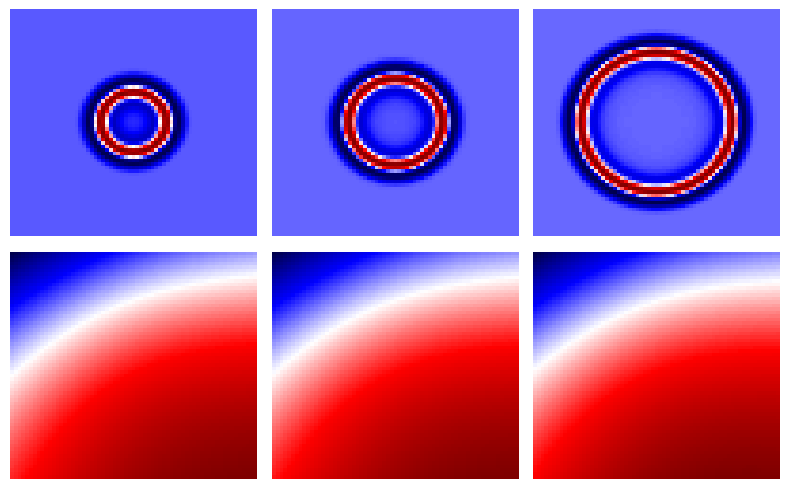

  2%|▏         | 995/50000 [00:06<05:12, 156.60it/s]

Epoch 1000 | Loss 0.667853 | Loss_ini 0.667851 | Loss_pde 0.020424


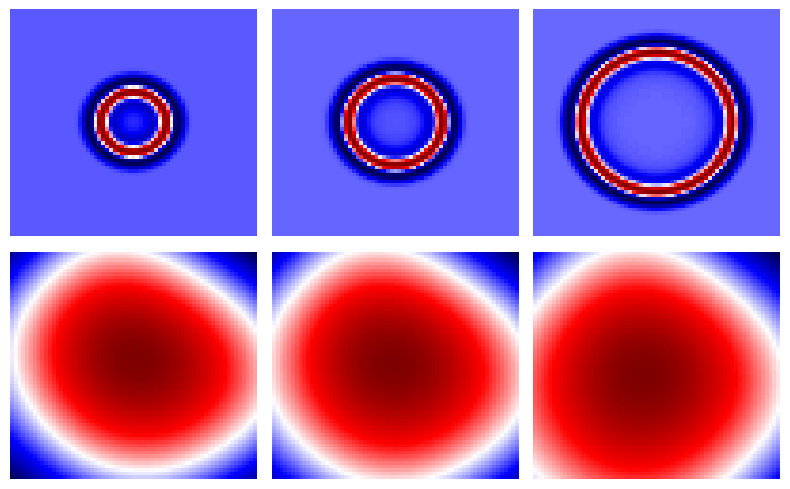

  4%|▍         | 1990/50000 [00:13<05:09, 155.27it/s]

Epoch 2000 | Loss 0.667721 | Loss_ini 0.667717 | Loss_pde 0.036627


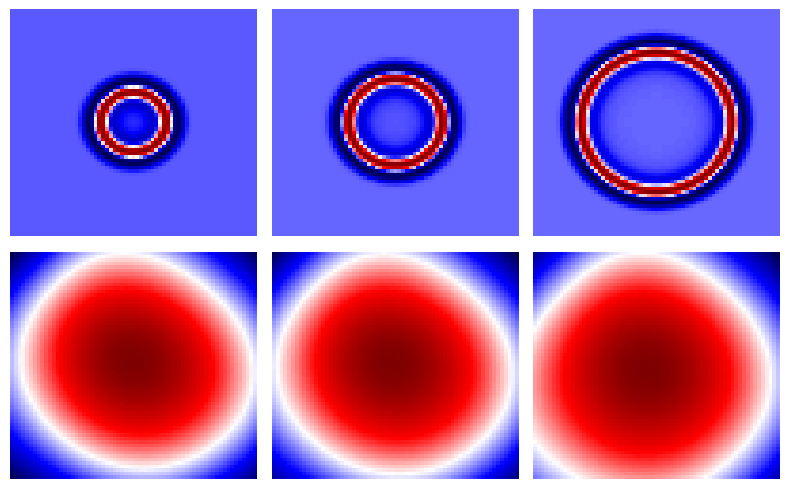

  6%|▌         | 2983/50000 [00:18<04:01, 194.45it/s]

Epoch 3000 | Loss 0.667268 | Loss_ini 0.667263 | Loss_pde 0.049707


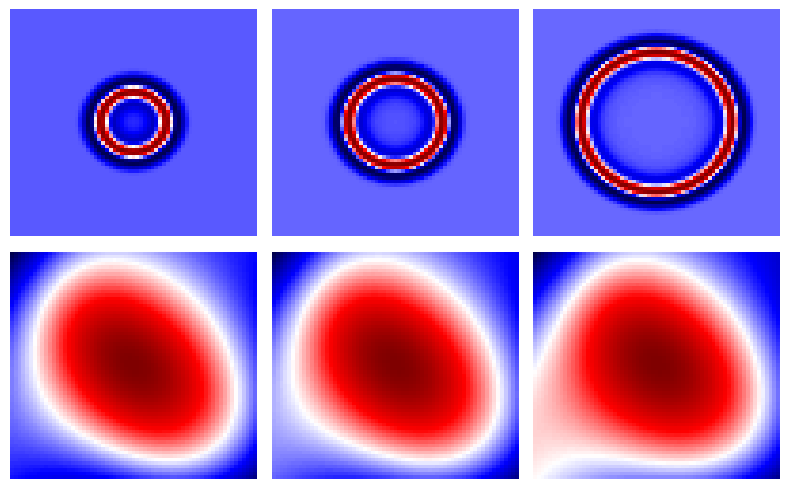

  8%|▊         | 3987/50000 [00:24<04:49, 158.84it/s]

Epoch 4000 | Loss 0.665838 | Loss_ini 0.665752 | Loss_pde 0.859032


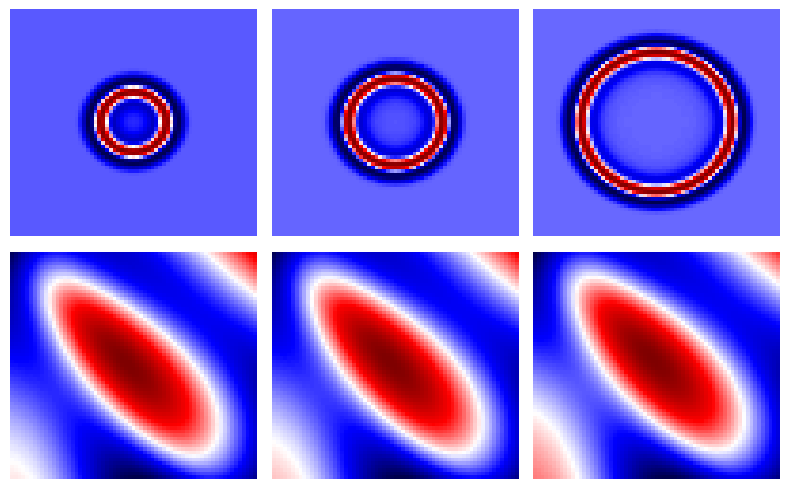

 10%|▉         | 4987/50000 [00:30<03:56, 190.16it/s]

Epoch 5000 | Loss 0.664817 | Loss_ini 0.664601 | Loss_pde 2.156802


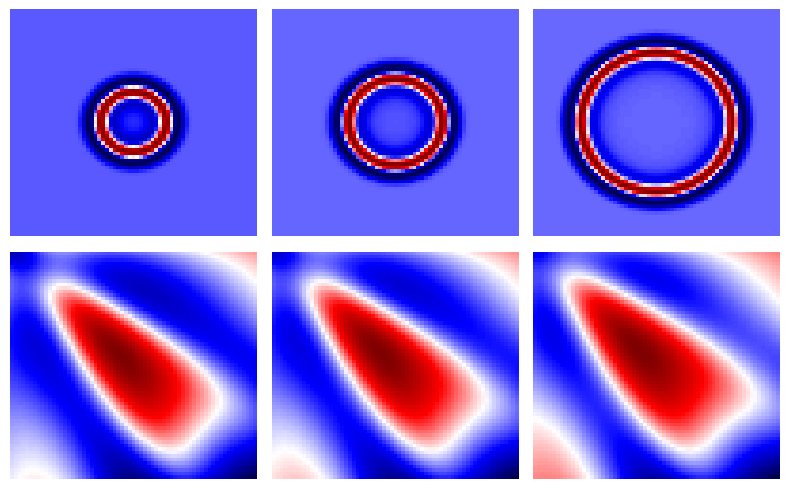

 12%|█▏        | 5986/50000 [00:36<04:41, 156.31it/s]

Epoch 6000 | Loss 0.660567 | Loss_ini 0.659855 | Loss_pde 7.112846


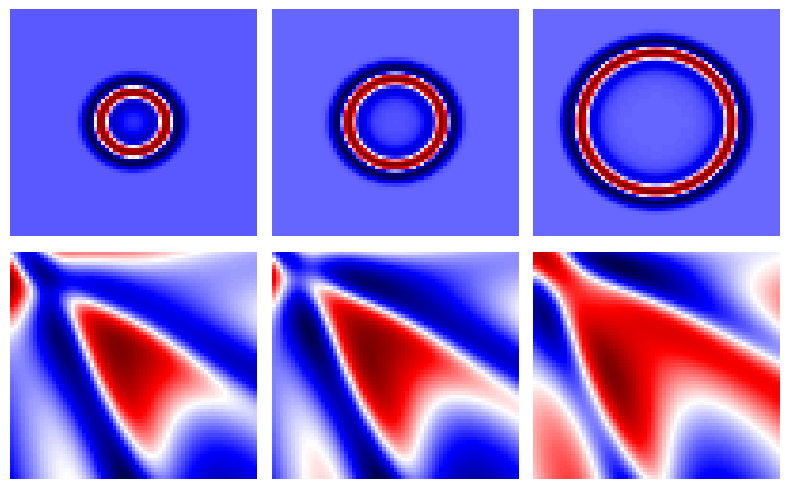

 14%|█▍        | 7000/50000 [00:42<03:43, 192.55it/s]

Epoch 7000 | Loss 0.611965 | Loss_ini 0.610002 | Loss_pde 19.626005


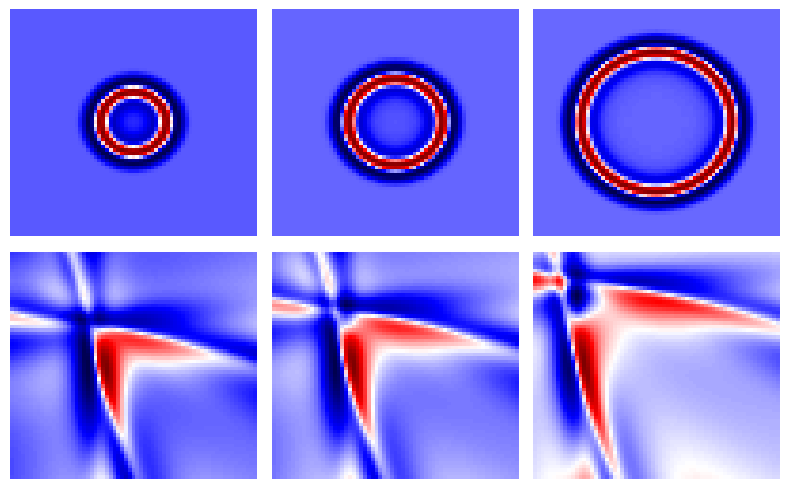

 16%|█▌        | 8000/50000 [00:47<03:35, 194.87it/s]

Epoch 8000 | Loss 0.411357 | Loss_ini 0.402457 | Loss_pde 88.992882


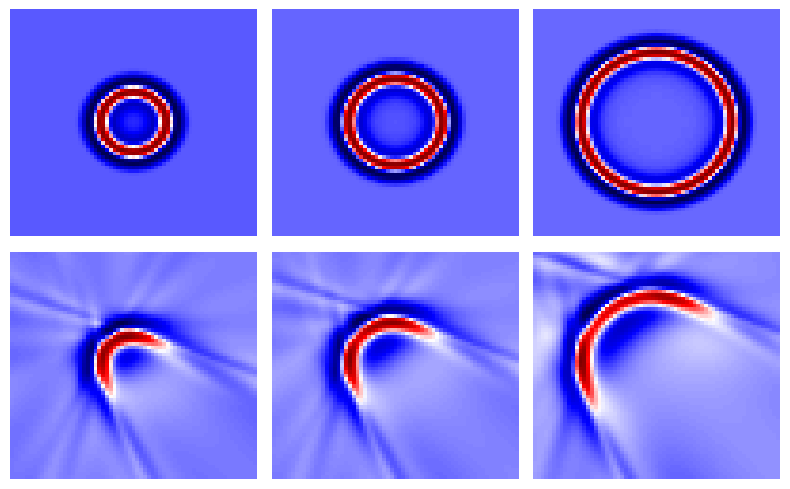

 18%|█▊        | 8999/50000 [00:53<03:31, 193.66it/s]

Epoch 9000 | Loss 0.168458 | Loss_ini 0.151740 | Loss_pde 167.179016


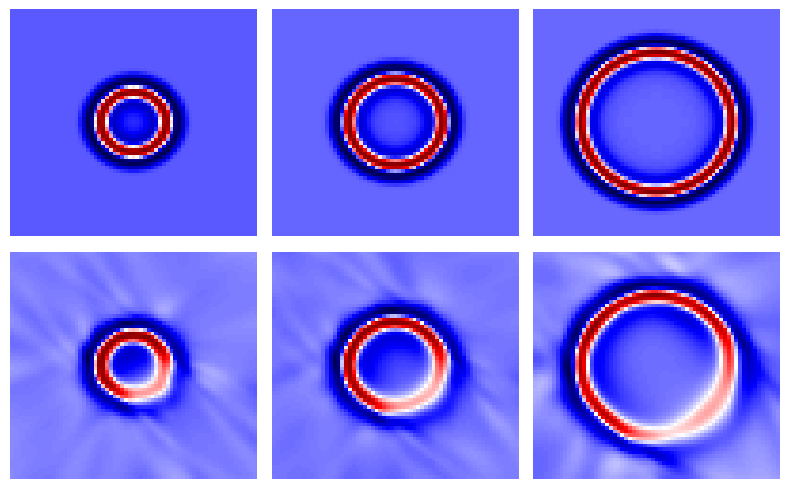

 20%|█▉        | 9999/50000 [00:58<03:25, 194.22it/s]

Epoch 10000 | Loss 0.039464 | Loss_ini 0.026186 | Loss_pde 132.772232


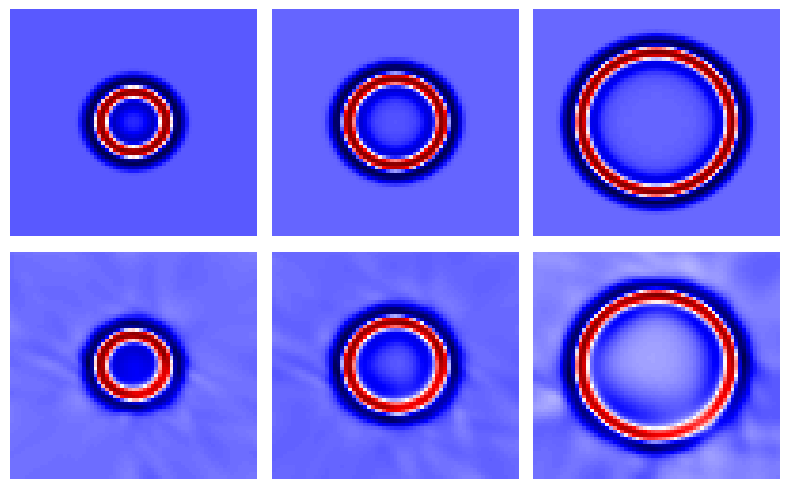

 22%|██▏       | 10997/50000 [01:03<03:20, 194.88it/s]

Epoch 11000 | Loss 0.013284 | Loss_ini 0.005959 | Loss_pde 73.249840


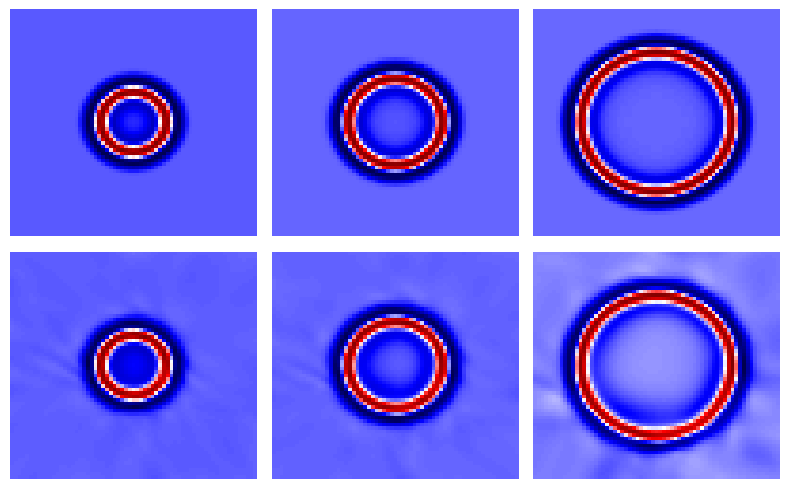

 24%|██▍       | 11997/50000 [01:09<03:14, 195.21it/s]

Epoch 12000 | Loss 0.006319 | Loss_ini 0.002469 | Loss_pde 38.498196


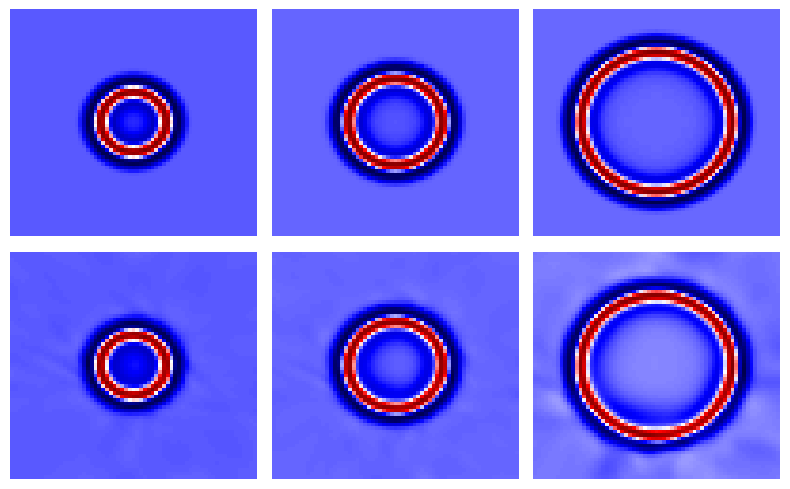

 26%|██▌       | 12997/50000 [01:14<03:10, 194.64it/s]

Epoch 13000 | Loss 0.003738 | Loss_ini 0.001351 | Loss_pde 23.866201


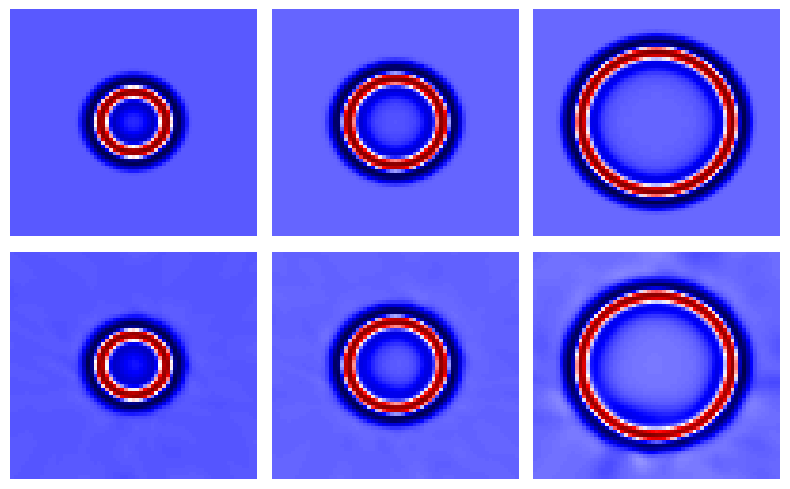

 28%|██▊       | 13996/50000 [01:19<03:04, 194.73it/s]

Epoch 14000 | Loss 0.002537 | Loss_ini 0.000893 | Loss_pde 16.443878


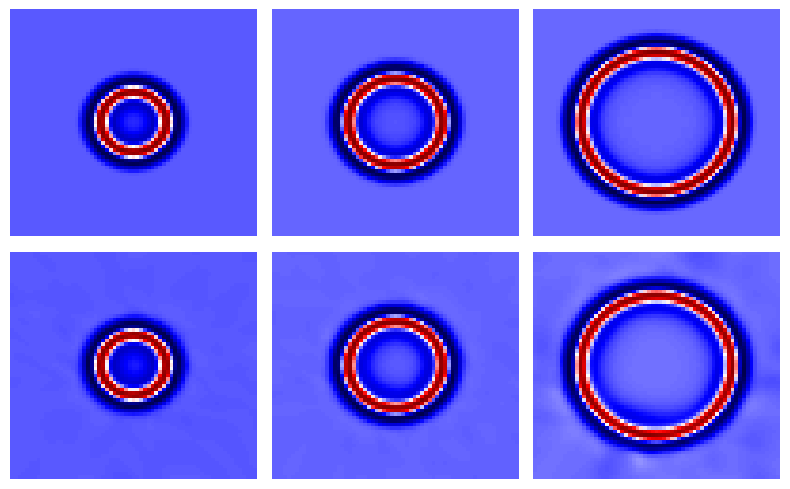

 30%|██▉       | 14996/50000 [01:25<03:01, 193.26it/s]

Epoch 15000 | Loss 0.001891 | Loss_ini 0.000662 | Loss_pde 12.292676


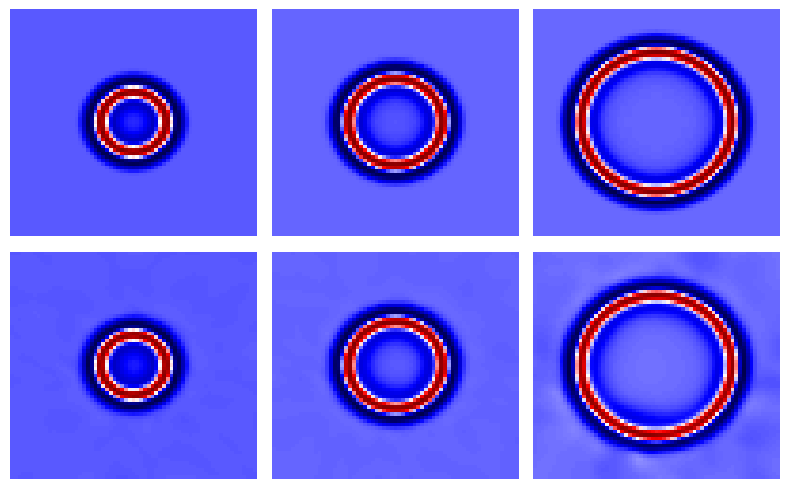

 32%|███▏      | 15993/50000 [01:30<02:55, 193.22it/s]

Epoch 16000 | Loss 0.001511 | Loss_ini 0.000531 | Loss_pde 9.798761


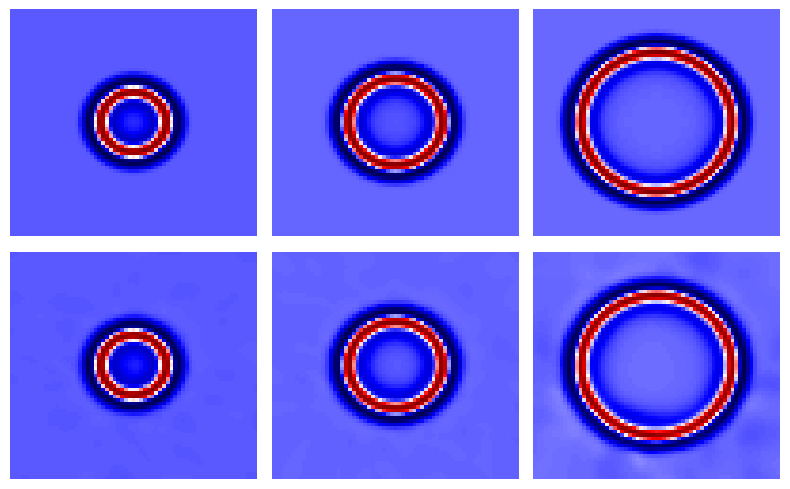

 34%|███▍      | 16993/50000 [01:36<02:50, 193.90it/s]

Epoch 17000 | Loss 0.001272 | Loss_ini 0.000456 | Loss_pde 8.161701


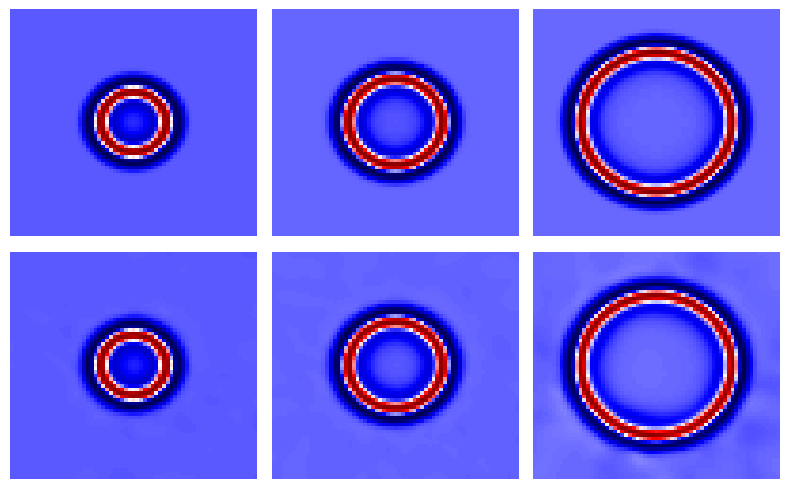

 36%|███▌      | 17998/50000 [01:42<03:22, 158.06it/s]

Epoch 18000 | Loss 0.001093 | Loss_ini 0.000393 | Loss_pde 7.003555


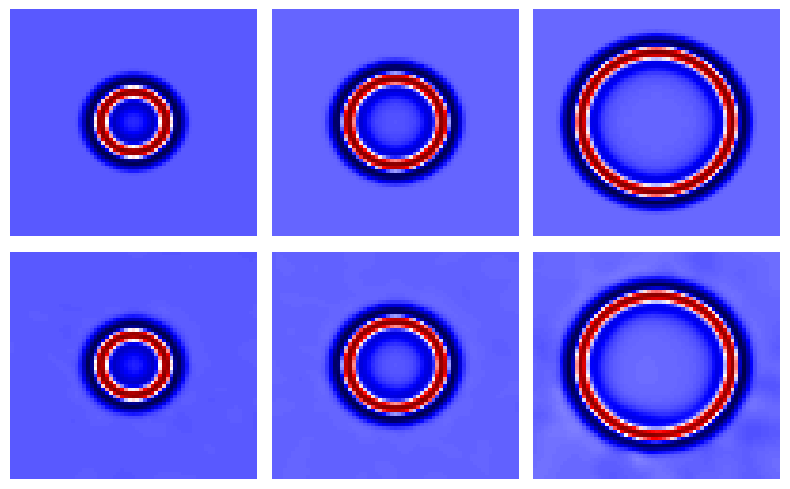

 38%|███▊      | 18990/50000 [01:48<03:17, 157.06it/s]

Epoch 19000 | Loss 0.000967 | Loss_ini 0.000352 | Loss_pde 6.141489


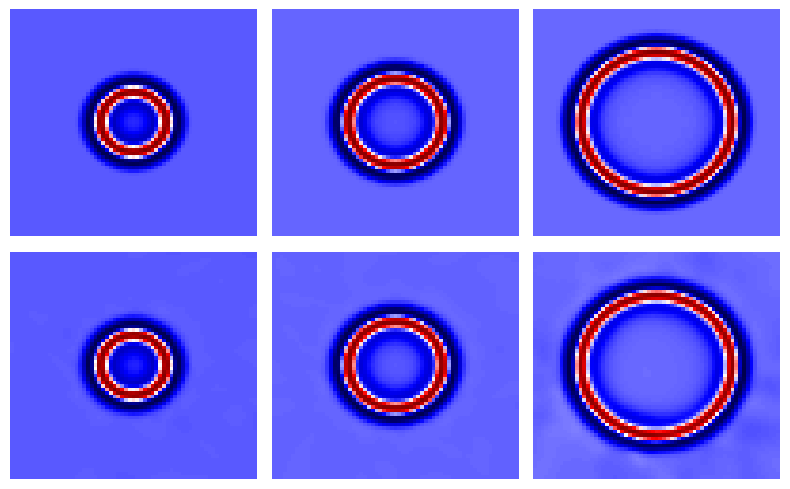

 40%|███▉      | 19992/50000 [01:55<02:41, 185.24it/s]

Epoch 20000 | Loss 0.000873 | Loss_ini 0.000326 | Loss_pde 5.477522


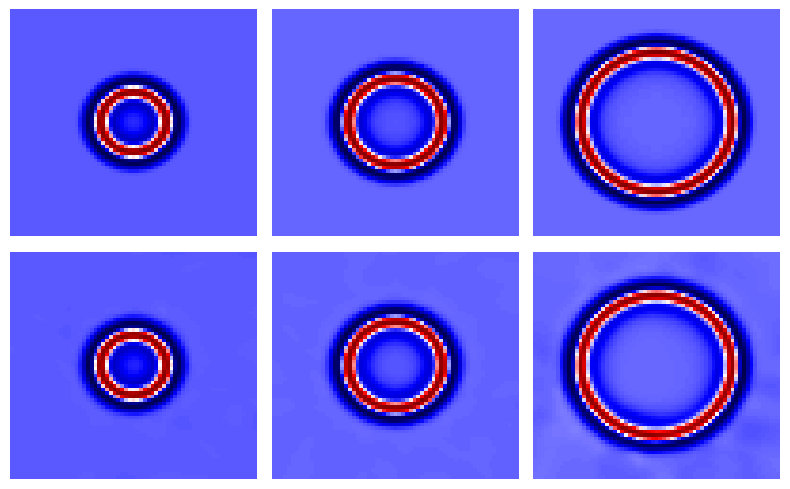

 42%|████▏     | 21000/50000 [02:00<02:32, 190.00it/s]

Epoch 21000 | Loss 0.000791 | Loss_ini 0.000297 | Loss_pde 4.939706


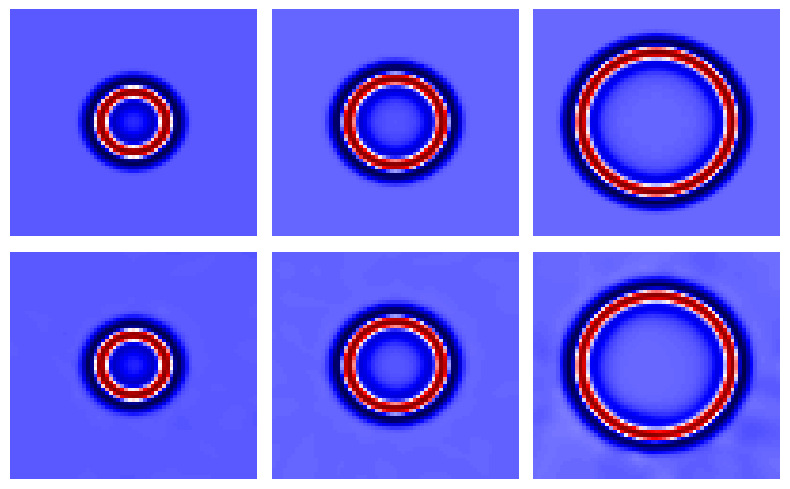

 44%|████▍     | 21988/50000 [02:06<02:27, 190.53it/s]

Epoch 22000 | Loss 0.000729 | Loss_ini 0.000278 | Loss_pde 4.507482


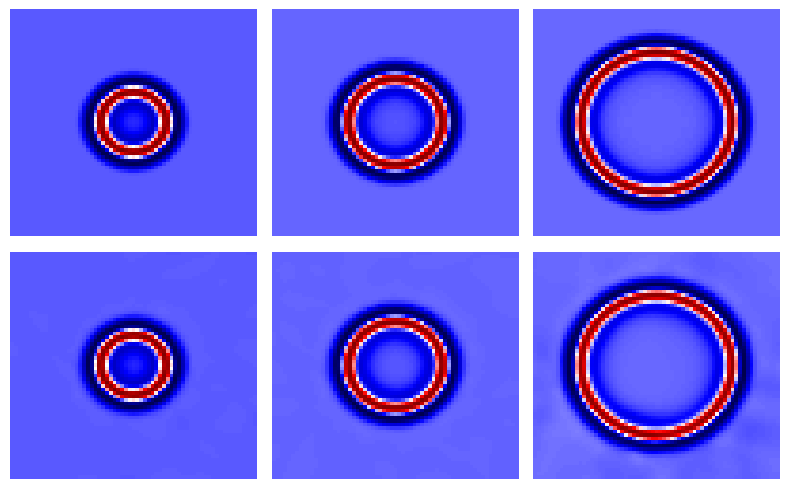

 46%|████▌     | 22984/50000 [02:11<02:20, 191.76it/s]

Epoch 23000 | Loss 0.000676 | Loss_ini 0.000261 | Loss_pde 4.144058


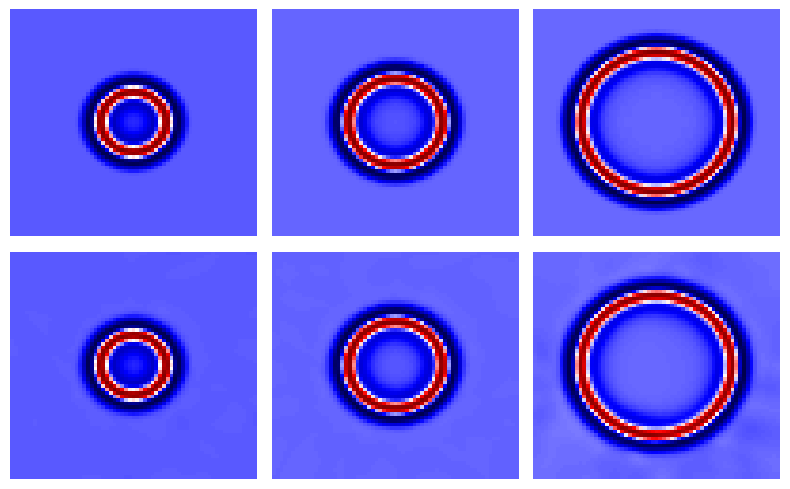

 48%|████▊     | 23992/50000 [02:17<02:16, 190.11it/s]

Epoch 24000 | Loss 0.000631 | Loss_ini 0.000248 | Loss_pde 3.832550


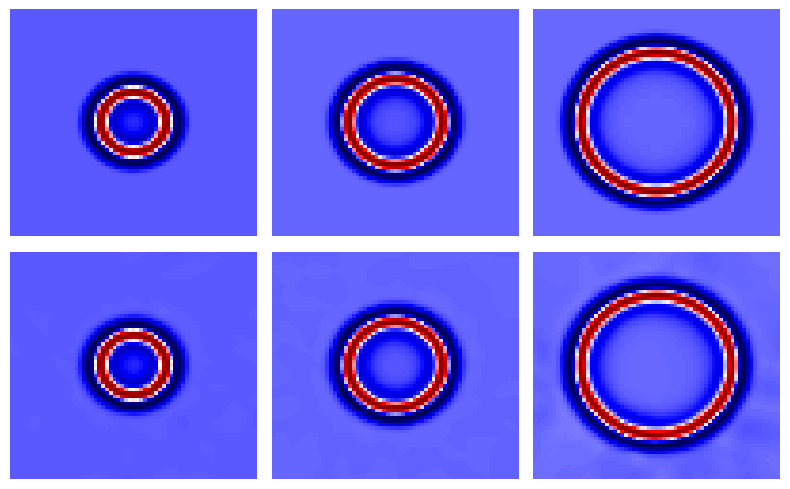

 50%|████▉     | 24984/50000 [02:22<02:11, 190.74it/s]

Epoch 25000 | Loss 0.000596 | Loss_ini 0.000239 | Loss_pde 3.568491


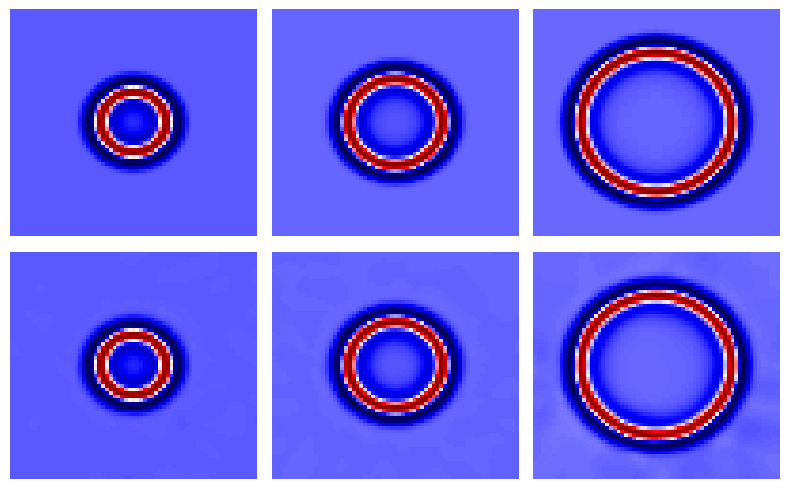

 52%|█████▏    | 25996/50000 [02:28<02:05, 190.78it/s]

Epoch 26000 | Loss 0.000558 | Loss_ini 0.000225 | Loss_pde 3.330020


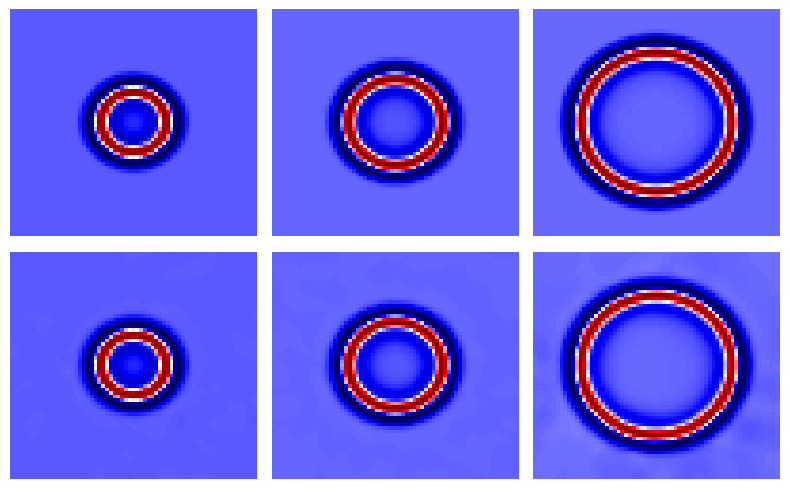

 54%|█████▍    | 26992/50000 [02:33<01:59, 191.77it/s]

Epoch 27000 | Loss 0.000529 | Loss_ini 0.000216 | Loss_pde 3.123135


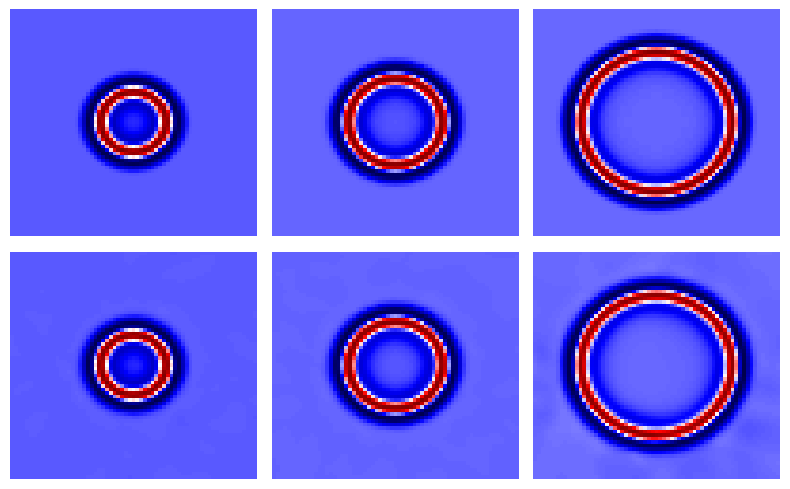

 54%|█████▍    | 27107/50000 [02:34<02:10, 175.68it/s]


KeyboardInterrupt: 

In [17]:
for i in tqdm.trange(epochs):

  optimizer.zero_grad()

  # Initial condition 1
  u0_pred = pinn(xx0, zz0, tt0)
  loss_u0 = F.mse_loss(u0_pred, u0.unsqueeze(1))

  # Initial condition 2
  u1_pred = pinn(xx0, zz0, tt1)
  loss_u1 = F.mse_loss(u1_pred, u1.unsqueeze(1))

  # loss of the initial condition
  loss_ini = loss_u0 + loss_u1

  # loss of the pde
  u = pinn(x_pde, z_pde, t_pde)
  kwargs = {'create_graph': True, 'retain_graph': True}
  u_t = torch.autograd.grad(u, t_pde, grad_outputs=torch.ones_like(u), **kwargs)[0]
  u_tt = torch.autograd.grad(u_t, t_pde, grad_outputs=torch.ones_like(u_t), **kwargs)[0]
  u_x = torch.autograd.grad(u, x_pde, grad_outputs=torch.ones_like(u), **kwargs)[0]
  u_xx = torch.autograd.grad(u_x, x_pde, grad_outputs=torch.ones_like(u_x), **kwargs)[0]
  u_z = torch.autograd.grad(u, z_pde, grad_outputs=torch.ones_like(u), **kwargs)[0]
  u_zz = torch.autograd.grad(u_z, z_pde, grad_outputs=torch.ones_like(u_z), **kwargs)[0]

  # loss of the pde
  u_pde = 1.5**2*(u_xx+u_zz) - u_tt
  loss_pde = F.mse_loss(u_pde, pde_zero)
  
  # total loss
  loss = loss_ini + 1e-4*loss_pde

  loss.backward()
  optimizer.step()
  if i%1000==0:
    print(f"Epoch {i} | Loss {loss.item():.6f} | Loss_ini {loss_ini.item():.6f} | Loss_pde {loss_pde.item():.6f}")
    with torch.no_grad():
      utest_pred = pinn(xx0, zz0, tt_test)
    utest_pred = utest_pred.detach().cpu().numpy().reshape(shape_after)
    fig, ax = plt.subplots(2,3, figsize=(8,5))
    show_d = [u0, u1, u_test, u0_pred, u1_pred, utest_pred]
    extent = [0, nx/1000, nz/1000, 0]
    for d, ax in zip(show_d, ax.ravel()):
        if isinstance(d, torch.Tensor):
            d = d.detach().cpu().numpy().reshape(shape_after)
        ax.imshow(d, extent=extent, cmap='seismic', aspect='auto')
        ax.set_xlabel('x (km)')
        ax.set_ylabel('z (km)')
        # disable the axis
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(f"./figures/train_{i:06d}.png", dpi=300)

In [ ]:
nx, dh

In [ ]:
dh = 10
grid1m_x = int(nx/(dh/1000))
grid1m_z = int(nz/(dh/1000))
xx, zz = np.meshgrid(np.linspace(0,nx,grid1m_x),np.linspace(0,nz,grid1m_z))
xx0 = to_tensor(xx.reshape((-1,1)))
zz0 = to_tensor(zz.reshape((-1,1)))
shape = xx.shape

In [ ]:
wf.shape

In [ ]:
# predict all the time
for t in range(1200):
    if t%25==0:
        tt = t*dt*np.ones(grid1m_x*grid1m_z)
        tt = to_tensor(tt.reshape((-1,1)))
        with torch.no_grad():
            u_pred = pinn(xx0, zz0, tt).detach().cpu().numpy().reshape(shape)
        fig, axes = plt.subplots(1,3,figsize=(6,3))
        axes[0].imshow(u_pred, extent=extent, cmap='seismic', aspect='auto')
        axes[1].imshow(wf[t+400], extent=extent, cmap='seismic', aspect='auto')
        axes[2].imshow(u_pred-wf[t+400], extent=extent, cmap='seismic', aspect='auto')
        for ax in axes.ravel():
            ax.set_title(f"Time {t*dt:.2f} s")
            ax.set_xlabel('x (km)')
            ax.set_ylabel('z (km)')
            ax.axis('off')
        plt.tight_layout()
        plt.show()